<a href="https://colab.research.google.com/github/WaterKnight1998/Distributed_Computing_For_Artificial_Intelligence/blob/master/ModeloClasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entregable 3: Construyendo un modelo de clasificación aplicando *fine-tuning*

En este notebook se muestra cómo crear un modelo de clasificación de imágenes utilizando la técnica de *transfer-learning* conocida como *fine-tuning*.

Para ello vamos a utilizar la librería [fastAI](https://www.fast.ai/). Este notebook está inspirado en el curso asociado a dicha librería. 

En esta práctica vamos a hacer un uso intensivo de la GPU, así que es importante activar su uso desde la opción *Notebook settings* del menú *Edit* . 

## Carga de librerías
Comenzamos cargando las librerías que vamos a necesitar en esta práctica. La librería fastai nos proporciona los distintos algoritmos de aprendizaje profundo y la librería os la utilizamos para la gestión de ficheros. 

In [0]:
from fastai.vision import *
import os
from google.colab import files

## Creando nuestro dataset de imágenes

El primer paso en cualquier proyecto de clasificación de imágenes es construir un dataset de imágenes anotadas. Aunque existen muchos datasets disponibles vamos a ver que con las técnicas explicadas en este notebook se pueden construir buenos modelos de clasificación para cualquier problema. 

En concreto, nuestro objetivo va a ser construir un modelo capaz de distinguir entre distinats variedades de uvas.

### Creando el dataset

Para crear nuestro dataset vamos a utilizar imágenes adquiridas desde Google Imágenes. Este proceso está inspirado por [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/).

#### Buscando imágenes

Ve a Google Imágenes e introduce el término de búsqueda "Philip J Fry". En los resultados mostrados desplazate hacia abajo en la página, todas las imágenes por encima del punto hasta el que llegues formarán parte de tu dataset. 

Ahora vamos a guardar las direcciones de las imágenes usando código JavaScript. Abre la consola web (en Firefox se abre al pulsar la combinación de teclas <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd>, en Chrome mediante la combinación <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd>). 

En dicha consola ejecuta los siguientes comandos:
```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=urg-8,'+escape(urls.join('\n')));
```
Esto genera un fichero csv con las URLs de las imágenes que formarán parte de tu dataset. 

Guarda dicho fichero con el nombre ``fry.csv``. Este proceso habría que repetirlo para las imágenes de Leela y de Bender (o para aquellas categorías que formen parte de tu dasaset). 

Para simplificar la tarea y obtener todos los mismos resultados en esta parte, puedes descargar los ficheros ``fry.csv``,  ``bender.csv`` y  ``leela.csv`` con el siguiente comando. 


In [6]:
!wget https://raw.githubusercontent.com/WaterKnight1998/IA1819Entregable3Datasets/master/capitanAmerica.csv -O capitanAmerica.csv
!wget https://raw.githubusercontent.com/WaterKnight1998/IA1819Entregable3Datasets/master/ironMan.csv -O ironMan.csv
!wget https://raw.githubusercontent.com/WaterKnight1998/IA1819Entregable3Datasets/master/thanos.csv -O thanos.csv

--2019-05-08 13:59:07--  https://raw.githubusercontent.com/WaterKnight1998/IA1819Entregable3Datasets/master/capitanAmerica.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40848 (40K) [text/plain]
Saving to: ‘capitanAmerica.csv’

capitanAmerica.csv  100%[===================>]  39.89K  --.-KB/s    in 0.01s   

2019-05-08 13:59:07 (3.19 MB/s) - ‘capitanAmerica.csv’ saved [40848/40848]

--2019-05-08 13:59:08--  https://raw.githubusercontent.com/WaterKnight1998/IA1819Entregable3Datasets/master/ironMan.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200

### Descargando las imágenes y organizando las carpetas

Habitualmente para crear modelos de clasificación de imágenes se crea una carpeta para cada clase de imagen (en este caso necesitaremos crear tres carpetas, una para fry, otra para bender y otra para leela).

En nuestro caso además de crear las carpetas debemos descargar las imágenes para ello debemos ejecutar las siguientes celdas (notad que el código es identico en los tres casos y lo único que cambia es la clase de las imágenes).

Es posible que al intentar descargar alguna imagen se produzcan errores, pero no son relevantes (solo indican que esa imagen no se ha podido descargar).


In [7]:
folder = 'thanos'
file = 'thanos.csv'
path = Path('data/avengers')
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)
os.rename(file,path/file)
# Como mucho descargamos 200 imágenes
download_images(path/file,dest)

Error https://cdn.cinepapaya.com/stat/img/static-cp/cine/newsstory/oh-por-thanos-tenemos-las-primeras-reacciones-a-avengers-infinity-war-main-1524600568.png HTTPSConnectionPool(host='cdn.cinepapaya.com', port=443): Read timed out. (read timeout=4)


In [8]:
folder = 'ironMan'
file = 'ironMan.csv'
path = Path('data/avengers')
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)
os.rename(file,path/file)
# Como mucho descargamos 200 imágenes
download_images(path/file,dest)

Error https://www.neodoc.es/wp-content/uploads/2017/06/iron-man-y-gesti%C3%B3n-documental.jpg HTTPSConnectionPool(host='www.neodoc.es', port=443): Max retries exceeded with url: /wp-content/uploads/2017/06/iron-man-y-gesti%C3%B3n-documental.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fbb74316fd0>, 'Connection to www.neodoc.es timed out. (connect timeout=4)'))
Error https://imgc.allpostersimages.com/img/print/posters/avengers-assemble-artwork-with-thor-hulk-iron-man-captain-america-hawkeye-black-widow-loki_a-G-13764941-13198931.jpg HTTPSConnectionPool(host='imgc.allpostersimages.com', port=443): Read timed out. (read timeout=4)
Error https://www.disfracesenlanube.es/thumbs/709x709/files/web/disfraz/mascota/perro/iron-man-perro.jpg HTTPSConnectionPool(host='www.disfracesenlanube.es', port=443): Max retries exceeded with url: /thumbs/709x709/files/web/disfraz/mascota/perro/iron-man-perro.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE

In [9]:
folder = 'capitanAmerica'
file = 'capitanAmerica.csv'
path = Path('data/avengers')
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)
os.rename(file,path/file)
# Como mucho descargamos 200 imágenes
download_images(path/file,dest)

Error https://www.dgpower.es/702-large_default/carcasa-capitan-america-apple-iphone-55sse.jpg HTTPSConnectionPool(host='www.dgpower.es', port=443): Max retries exceeded with url: /702-large_default/carcasa-capitan-america-apple-iphone-55sse.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:847)'),))
Error https://www.ecured.cu/images/thumb/f/f8/Capitan-america.jpg/260px-Capitan-america.jpg HTTPSConnectionPool(host='www.ecured.cu', port=443): Max retries exceeded with url: /images/thumb/f/f8/Capitan-america.jpg/260px-Capitan-america.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fbb742ed978>, 'Connection to www.ecured.cu timed out. (connect timeout=4)'))
Error https://frikipolis.com/wp-content/uploads/2018/10/figura-hasbro-15cm-capitan-america-marvel.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
Error http://vi%C3%B1etascomic.com/5835-lar

Puede ocurrir que algunas imágenes tengan un formato que no pueda ser abierto por la librería, por lo que vamos a eliminarlas con la siguiente instrucción.

In [10]:
for c in ['thanos','ironMan','capitanAmerica']:
  print(c)
  verify_images(path/c,delete=True,max_size=500)

thanos


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:967: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


int() argument must be a string, a bytes-like object or a number, not 'tuple'
cannot identify image file <_io.BufferedReader name='data/avengers/thanos/00000320.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:967: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


int() argument must be a string, a bytes-like object or a number, not 'tuple'
cannot identify image file <_io.BufferedReader name='data/avengers/thanos/00000020.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:967: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


int() argument must be a string, a bytes-like object or a number, not 'tuple'
ironMan


cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000175.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:967: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


int() argument must be a string, a bytes-like object or a number, not 'tuple'
cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000176.jpg'>
cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000141.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:967: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


int() argument must be a string, a bytes-like object or a number, not 'tuple'


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000005.jpg'>
cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000352.jpg'>
cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000331.jpg'>
cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000090.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:967: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


int() argument must be a string, a bytes-like object or a number, not 'tuple'
cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000325.jpg'>
cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000380.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000368.jpg'>
cannot identify image file <_io.BufferedReader name='data/avengers/ironMan/00000136.jpg'>
capitanAmerica


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file <_io.BufferedReader name='data/avengers/capitanAmerica/00000345.jpg'>
cannot identify image file <_io.BufferedReader name='data/avengers/capitanAmerica/00000042.jpg'>
cannot identify image file <_io.BufferedReader name='data/avengers/capitanAmerica/00000396.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file <_io.BufferedReader name='data/avengers/capitanAmerica/00000142.png'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file <_io.BufferedReader name='data/avengers/capitanAmerica/00000384.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


### Mostrando imágenes del dataset

Vamos a ver alguna de las imágenes de nuestro dataset para ello vamos a utilizar la clase ``ImageDataBunch`` que sirve para cargar los datos de distinta maneras (en este caso, a partir de una organización de carpetas). 

Almacenaremos el dataset en la variable ``data``. De nuestro dataset de imágenes vamos a usar un 20% como dataset de validación (parámetro ``valid_pct``), se aplican también distintas técnicas de aumento (parámetro ``ds_tfms``, crea una nueva celda y ejecuta la instrucción ``get_transforms()`` para ver las técnicas de aumento que se están utilizando), las imágenes se reescalan a tamaño 224 (este es el tamaño de entrada que espera que tengan las imágenes la red neuronal que construiremos un poco más adelante), y se normalizan utilizando el dataset de ImageNet. 

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,ds_tfms=get_transforms(),size=224,num_workers=4).normalize(imagenet_stats)

Mostramos un batch del dataset que acabamos de cargar. 

In [0]:
data.show_batch(rows=3,figsize=(7,8))

## Creando el modelo de predicción

A continuación vamos a crear nuestra red convolucional usando *transfer learning* y utilizando como base la arquitectura [ResNet 34](https://arxiv.org/abs/1512.03385); aunque existen otros [modelos disponibles](https://pytorch.org/docs/stable/torchvision/models.html) este modelo proporciona buenos resultados. Al crear nuestra red convolucional también debemos indicar la [métrica](https://docs.fast.ai/metrics.html#metrics) que vamos a utilizar para medir el rendimiento del modelo, en este caso vamos a usar el error_rate y la accuracy.

La primera vez que se ejecuta la siguiente instrucción puede llevar algún tiempo debido a que se tienen que descargar los pesos asociados a la red ResNet 34. 

In [13]:
learn = create_cnn(data,models.resnet34,metrics=[error_rate,accuracy])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 93957399.64it/s]


### Entrenando la red

El siguiente paso es entrenar la red. Para ello vamos a utilizar el [siguiente procedimiento](https://sgugger.github.io/the-1cycle-policy.html) basado en la idea de fine-tuning:

1. En primer lugar se dejan fijos (congelados) los pesos de la mayoría de capas de la red y sólo se actualizan los de las últimas capas. 
2. Se descongelan todas las capas de la red. 
3. Se reentrenan todas las capas de la red pero utilizando distintos *learning rates* en cada capa. 

La librería fastai proporciona toda la funcionalidad necesaria para llevar a cabo este proceso.

#### Actualizando los pesos de las últimas capas

Para llevar a cabo la actualización de pesos de las últimas capas hay que emplear la siguiente instrucción (**Importante.** Activar el uso de GPUs de lo contrario puede llevar demasiado tiempo este proceso).

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.003678,0.445142,0.147826,0.852174,00:14
1,0.710032,0.337972,0.086957,0.913043,00:14
2,0.550230,0.327471,0.086957,0.913043,00:14
3,0.455690,0.322547,0.082609,0.917391,00:14


Con el proceso anterior conseguimos aproximandamente una accuracy del 80% (notar que el valor del error_rate y la accuracy están relacionados). Para empezar esta accuracy no está mal, pero podemos mejorarla. 

Vamos a guardar el estado de nuestra red con el siguiente comando.

In [0]:
learn.save('stage-1')

#### Descongelando la red

La instrucción para descongelar las capas de la red es la siguiente. 

In [0]:
learn.unfreeze()

#### Reentrenando las capas de la red

Una vez que hemos descongelado las capas de la red vamos a entrenarlas, pero vamos a usar distintos ratios de aprendizaje para las capas de la red. La idea es que para las capas del principio de la red vamos a utilizar un *learning rate* pequeño y para las últimas usaremos un *learning rate* algo más alto. 

Esto es debido a que las capas del principio de la red se encargan de codificar patrones básicos de las imágenes (como colores, bordes, etc.) que son aplicables a la mayoría de imágenes y por lo tanto no es necesario realizar grandes modificaciones en los pesos de esas capas. Por el contrario las últimas capas de la red son más específicas y dependen del problema con el que estemos tratando por lo que los pasos de aprendizaje pueden ser algo mayores. 

Para una explicación detallada de cómo encontrar el valor adecuado del learning rate puedes ver el [blog de Sylvain Gugger](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) o la [documentación de fastai](https://docs.fast.ai/callbacks.lr_finder.html#LRFinder). En general, unos valores que suelen proporcionar buenos resultados son los utilizados en la siguiente instrucción:



In [18]:
learn.fit_one_cycle(4,max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.287274,0.321161,0.091304,0.908696,00:14
1,0.247448,0.333651,0.086957,0.913043,00:14
2,0.213459,0.345519,0.095652,0.904348,00:14
3,0.186865,0.344542,0.095652,0.904348,00:14


Con el proceso anterior somos capaces de mejorar de manera considerable el rendimiento del modelo. Antes de seguir entrenando por más tiempo es combeniente realizar un análisis de los resultados. Pero antes de pasar a ese paso vamos a guardar el estado de nuestra red. 

In [0]:
learn.save('stage-2')

## Interpretación de los resultados

Vamos a interpretar los resultados utilizando la matriz de confusión. Para ello comenzamos cargando el estado anterior de la red. 

In [20]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (920 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
capitanAmerica,capitanAmerica,capitanAmerica,capitanAmerica,capitanAmerica
Path: data/avengers;

Valid: LabelList (230 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
capitanAmerica,thanos,thanos,capitanAmerica,thanos
Path: data/avengers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1):

A continuación se crear una interpretación de los resultados obtenidos con la misma. 

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

Por último mostramos la matriz de confusión obtenida. Además de la matriz de confusión se puede obtener [otra información](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation).

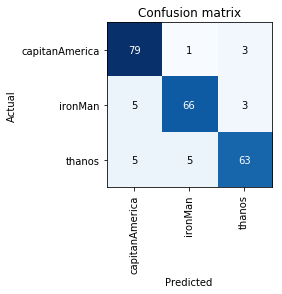

In [24]:
interp.plot_confusion_matrix()

Como podemos ver en la matriz de confusión anterior, el modelo tiende a confundir a Leela con Fry, esto puede deberse a que tengamos cierto ruido en nuestras imágenes (por ejemplo, imágenes que contengan a ambos personajes). Por lo tanto es conveniente limpiar nuestro dataset.

Limpiando el dataset

Como hemos comentado anteriormente puede ocurrir que haya imágenes en nuestro dataset que no deberían estar ahí.

In [0]:
from fastai.widgets import *

En primer lugar debemos encontrar los paths de las imágenes que tienen una mayor pérdida (es decir, aquellas que el modelo clasifica peor). Esto se puede hacer con .from_toplosses. 

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn,ds_type=DatasetType.Valid)

A continuación se listan los paths de las 10 imágenes con mayor pérdida. 

In [27]:
ds.to_df().iloc[idxs[:10]]

,x,y
692,ironMan/00000360.png,ironMan
806,ironMan/00000383.jpg,ironMan
343,thanos/00000091.jpg,thanos
761,ironMan/00000106.jpg,ironMan
250,capitanAmerica/00000012.jpg,capitanAmerica
435,thanos/00000037.jpg,thanos
822,ironMan/00000016.jpg,ironMan
653,ironMan/00000092.png,ironMan
283,capitanAmerica/00000261.jpg,capitanAmerica
255,capitanAmerica/00000329.jpg,capitanAmerica


Vamos a mostrar las cinco primeras imágenes de la lista.

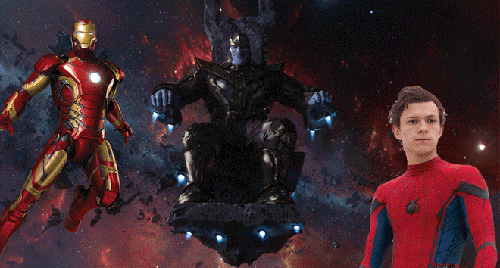

In [29]:
img = open_image(path/'ironMan'/'00000360.png')
img

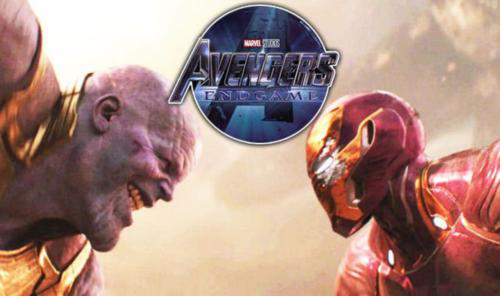

In [30]:
img = open_image(path/'ironMan'/'00000383.jpg')
img

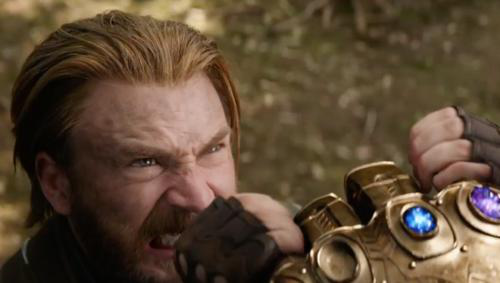

In [31]:
img = open_image(path/'thanos'/'00000091.jpg')
img

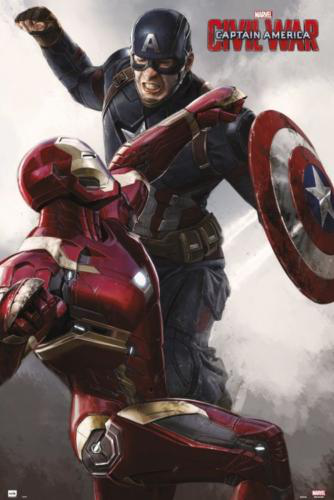

In [32]:
img = open_image(path/'ironMan'/'00000106.jpg')
img

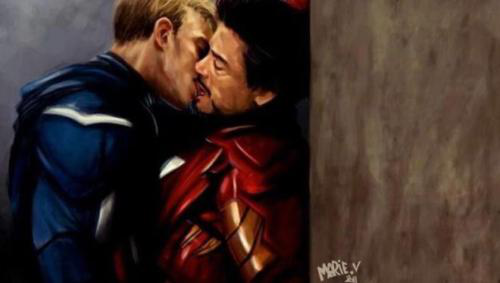

In [33]:
img = open_image(path/'capitanAmerica'/'00000012.jpg')
img

Como se puede apreciar hay ciertas imágenes en nuestro dataset que no son correctas, por lo que deberíamos hacer una limpieza del mismo para conseguir mejores resultados. 

## Poniendo el modelo en producción

Lo último que vamos a ver es cómo se puede poner el modelo en producción para usarlo para predecir la categoría de nuevas imágenes. 

Lo primero debemos exportar el modelo. La siguiente instrucción crea un fichero llamado 'export.pkl' en el directorio donde estamos trabajando (está almacenado en la variable ``path``) que sirve para desplegar el modelo. 

In [0]:
learn.export()

Podemos ver que se ha creado dicho fichero.

In [35]:
!ls data/futurama

ls: cannot access 'data/futurama': No such file or directory


A continuación indicamos al sistema que use la CPU para el proceso de inferncia (en caso de que el ordenador donde se despliega el modelo no tenga una GPU esto ocurre de manera automática).

In [0]:
defaults.device = torch.device('cpu')

Vamos a probar nuestro modelo con una nueva imagen, en este caso de Fry. Comenzamos descargando dicha imagen, y a continuación la abrimos.

In [37]:
!wget https://www.geek.com/wp-content/uploads/2019/04/thanos-farm-625x351.jpg -O thanos.png

--2019-05-08 14:19:05--  https://www.geek.com/wp-content/uploads/2019/04/thanos-farm-625x351.jpg
Resolving www.geek.com (www.geek.com)... 192.33.31.176
Connecting to www.geek.com (www.geek.com)|192.33.31.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24301 (24K) [image/jpeg]
Saving to: ‘thanos.png’

thanos.png          100%[===================>]  23.73K  --.-KB/s    in 0.02s   

2019-05-08 14:19:06 (1.12 MB/s) - ‘thanos.png’ saved [24301/24301]



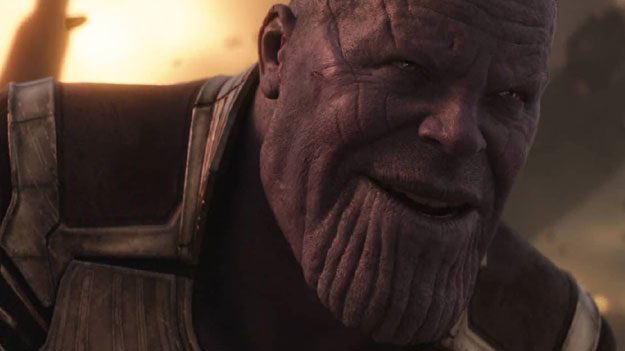

In [38]:
img = open_image('thanos.png')
img

A continuación creamos nuestro Learner.

In [0]:
learn = load_learner(path)

Y por último realizamos la predicción. 

In [40]:
pred_class,pred_idx,outputs=learn.predict(img)
pred_class

Category thanos